<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/226_rescorla_wagner.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(notebook-rescorla-wagner)=
# Apprendimento per rinforzo

Per illustrare un esempio di stima dei parametri mediante massima verosimiglianza, prendiamo in considerazione uno dei modelli psicologici di maggior successo: il modello di apprendimento di Rescorla-Wagner. Questo modello offre una possibile spiegazione al processo di apprendimento associativo e dipende da due parametri fondamentali: $\alpha$ e $\beta$. Vedremo come il metodo della massima verosimiglianza può essere impiegato per stimare tali parametri utilizzando i dati empirici ottenuti da un partecipante coinvolto in un compito di apprendimento associativo.

Il presente tutorial trae ispirazione dall'articolo di [Wilson & Collins (2019)](https://elifesciences.org/articles/49547) e utilizza il codice fornito da [Rhoads, S. A. & Gan, L. (2022)](https://shawnrhoads.github.io/gu-psyc-347/index.html).

In [1]:
import numpy as np  # matrix/array functions
import pandas as pd  # loading and manipulating data
import matplotlib.pyplot as plt  # plotting
import seaborn as sns
from scipy.optimize import minimize  # finding optimal params in models
import arviz as az

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Teoria: il modello Rescorla-Wagner

Lo scopo degli studi sull'apprendimento per rinforzo è quello di comprendere come le persone imparano a massimizzare le loro ricompense in situazioni in cui la scelta migliore è inizialmente sconosciuta. In modo più specifico, consideriamo il seguente problema di apprendimento. Un partecipante deve effettuare ripetutamente delle scelte tra diverse opzioni o azioni, e dopo ogni scelta riceve una ricompensa numerica estratta da una distribuzione di probabilità che dipende dall'azione selezionata. L'obiettivo del partecipante è massimizzare la ricompensa totale attesa durante un certo periodo di tempo, ad esempio, durante 100 scelte. Per descrivere questa situazione, viene spesso utilizzata la metafora di un giocatore che deve fare una serie di $T$ scelte tra $K$ slot machine (conosciute anche come "multi-armed bandits") al fine di massimizzare le sue vincite. Se nella scelta $t$ viene selezionata la slot machine $k$, viene ottenuta una ricompensa $r_t$ che ha valore `1` con una probabilità di successo $\mu^k_t$, altrimenti ha valore `0`. Le probabilità di successo sono diverse per ogni slot machine e inizialmente sono sconosciute al partecipante. Nella versione più semplice di questo compito, le probabilità di successo rimangono costanti nel tempo.

## Simulare l'apprendimento

In questo problema, ogni scelta ha un valore associato, che rappresenta la ricompensa attesa quando quella specifica scelta viene selezionata. Chiamiamo questo valore "valore della scelta". Se si conosce il valore di ogni scelta, risolvere il problema di apprendimento significa semplicemente selezionare la scelta con il valore più alto.

Abbiamo tre parametri per questo problema:
1. il numero di tentativi, $T$;
2. il numero di slot machine, $K$;
3. le probabilità di ricompensa delle diverse opzioni, $\mu^k_t$, che possono o meno variare nel tempo.

In questo tutorial simuleremo il comportamento di due slot machine basato sul modello di apprendimento Rescorla-Wagner. Imposteremo `T = 100` (100 tentativi), `K = 2` (due slot machine) e `mu = [.2, .8]` (la slot machine 1 fornisce una ricompensa con probabilità del 20%, la slot machine 2 fornisce una ricompensa con probabilità dell'80%).

In [3]:
T = 100
K = 2
mu = [0.2, 0.8]

### La regola di apprendimento per rinforzo ($\delta$-rule)

Rescorla e Wagner (1972) hanno formulato, in uno degli articoli più influenti del XX secolo, l'ipotesi che l'apprendimento avvenga tramite la rilevazione degli errori di previsione. Nel loro modello, i partecipanti acquisiscono inizialmente le aspettative di valore per ciascuna slot machine basandosi sulla storia dei risultati pregressi, e utilizzano tali valori per guidare le loro decisioni future.

**Equazione di Aggiornamento (Rescorla-Wagner)**

Il modello di Rescorla-Wagner rappresenta un modello di apprendimento fondato sull'errore di previsione, in cui gli stimoli acquisiscono valore quando emerge una discordanza tra la previsione e l'esito:

\begin{equation}
V_{s,t} = V_{s,t-1} + \alpha (r_{t-1} - V_{s,t-1}),
\end{equation}

dove

- $V_{s,t}$ rappresenta il valore dello stimolo "s" al tempo "t", il quale riflette l'aspettativa di una ricompensa.
- $r_{t-1}$ denota la ricompensa ottenuta nell'istante precedente "t-1".
- $\alpha$, che varia tra 0 e 1, corrisponde al tasso di apprendimento.

In questo modo, il valore viene aggiornato secondo l'errore di previsione, ovvero la differenza tra la ricompensa ricevuta "r" e l'aspettativa "V".

Il tasso di apprendimento definisce l'entità con cui viene ponderato tale errore di previsione; ad esempio, un valore $\alpha$ maggiore attribuisce un peso più rilevante all'errore di previsione.

### Softmax

All'inizio di ogni prova, il partecipante è chiamato a decidere quale slot machine scegliere, basandosi sui valori dei due stimoli. Il partecipante può:

* Scegliere sempre lo stimolo con il valore più alto.
* Oppure, a volte, esplorare se l'altra slot machine potrebbe essere migliore.

Nonostante la prima opzione porterebbe al massimo numero di ricompense in questo compito, sia gli esseri umani che gli animali spesso evitano di adottare questa strategia di "massimizzazione della probabilità" (ovvero, scegliere sempre lo stimolo con la probabilità più alta di ricompensa). Invece, tendono a selezionare lo stimolo con la probabilità di successo più alta con maggiore frequenza, ma non costantemente. Tuttavia, vi sono differenze nella quantità di "esplorazione" che integrano nel loro comportamento. Per catturare queste varie strategie di scelta (*exploration vs exploitation*), si ricorre a un modello che possa rappresentarle. A tale scopo, viene utilizzata l'equazione softmax:

\begin{align}
p(s) = \frac{exp(\beta \cdot V_{s})}{\sum_i exp(\beta \cdot V_{i})},
\end{align}

dove il parametro $\beta$, chiamato "temperatura", regola il grado di casualità nella scelta. Varia da $\beta = 0$ per rappresentare scelte completamente casuali fino a $\beta = \infty$ per rappresentare la scelta deterministica dell'opzione con il valore più alto. In altre parole, un individuo con un alto valore di $\beta$ sceglierà quasi sempre l'opzione con il valore più elevato ($V^k_t$), mentre uno con un basso valore di $\beta$ esplorerà più frequentemente altre opzioni.

Esaminiamo l'impatto di $\beta$ sulla probabilità di scelta. Supponiamo di avere 2 stimoli, A e B, dove il valore di B è sempre [1 - valore di A]. Nel grafico sottostante, abbiamo assunto un valore di $\beta$ pari a 3 e abbiamo illustrato la probabilità di scegliere A in relazione al suo valore.

Iniziamo definendo la funzione softmax.

In [4]:
def softmax(beta=3):
    va = np.arange(0, 1.02, 0.02)
    vb = 1 - va
    x = 0.02

    pa = np.exp(beta * va) / (np.exp(beta * va) + np.exp(beta * vb))
    tmp = np.random.rand(51) < pa * (1 + x)
    data = tmp
    x_axis = va - vb
    return pa, data, x_axis

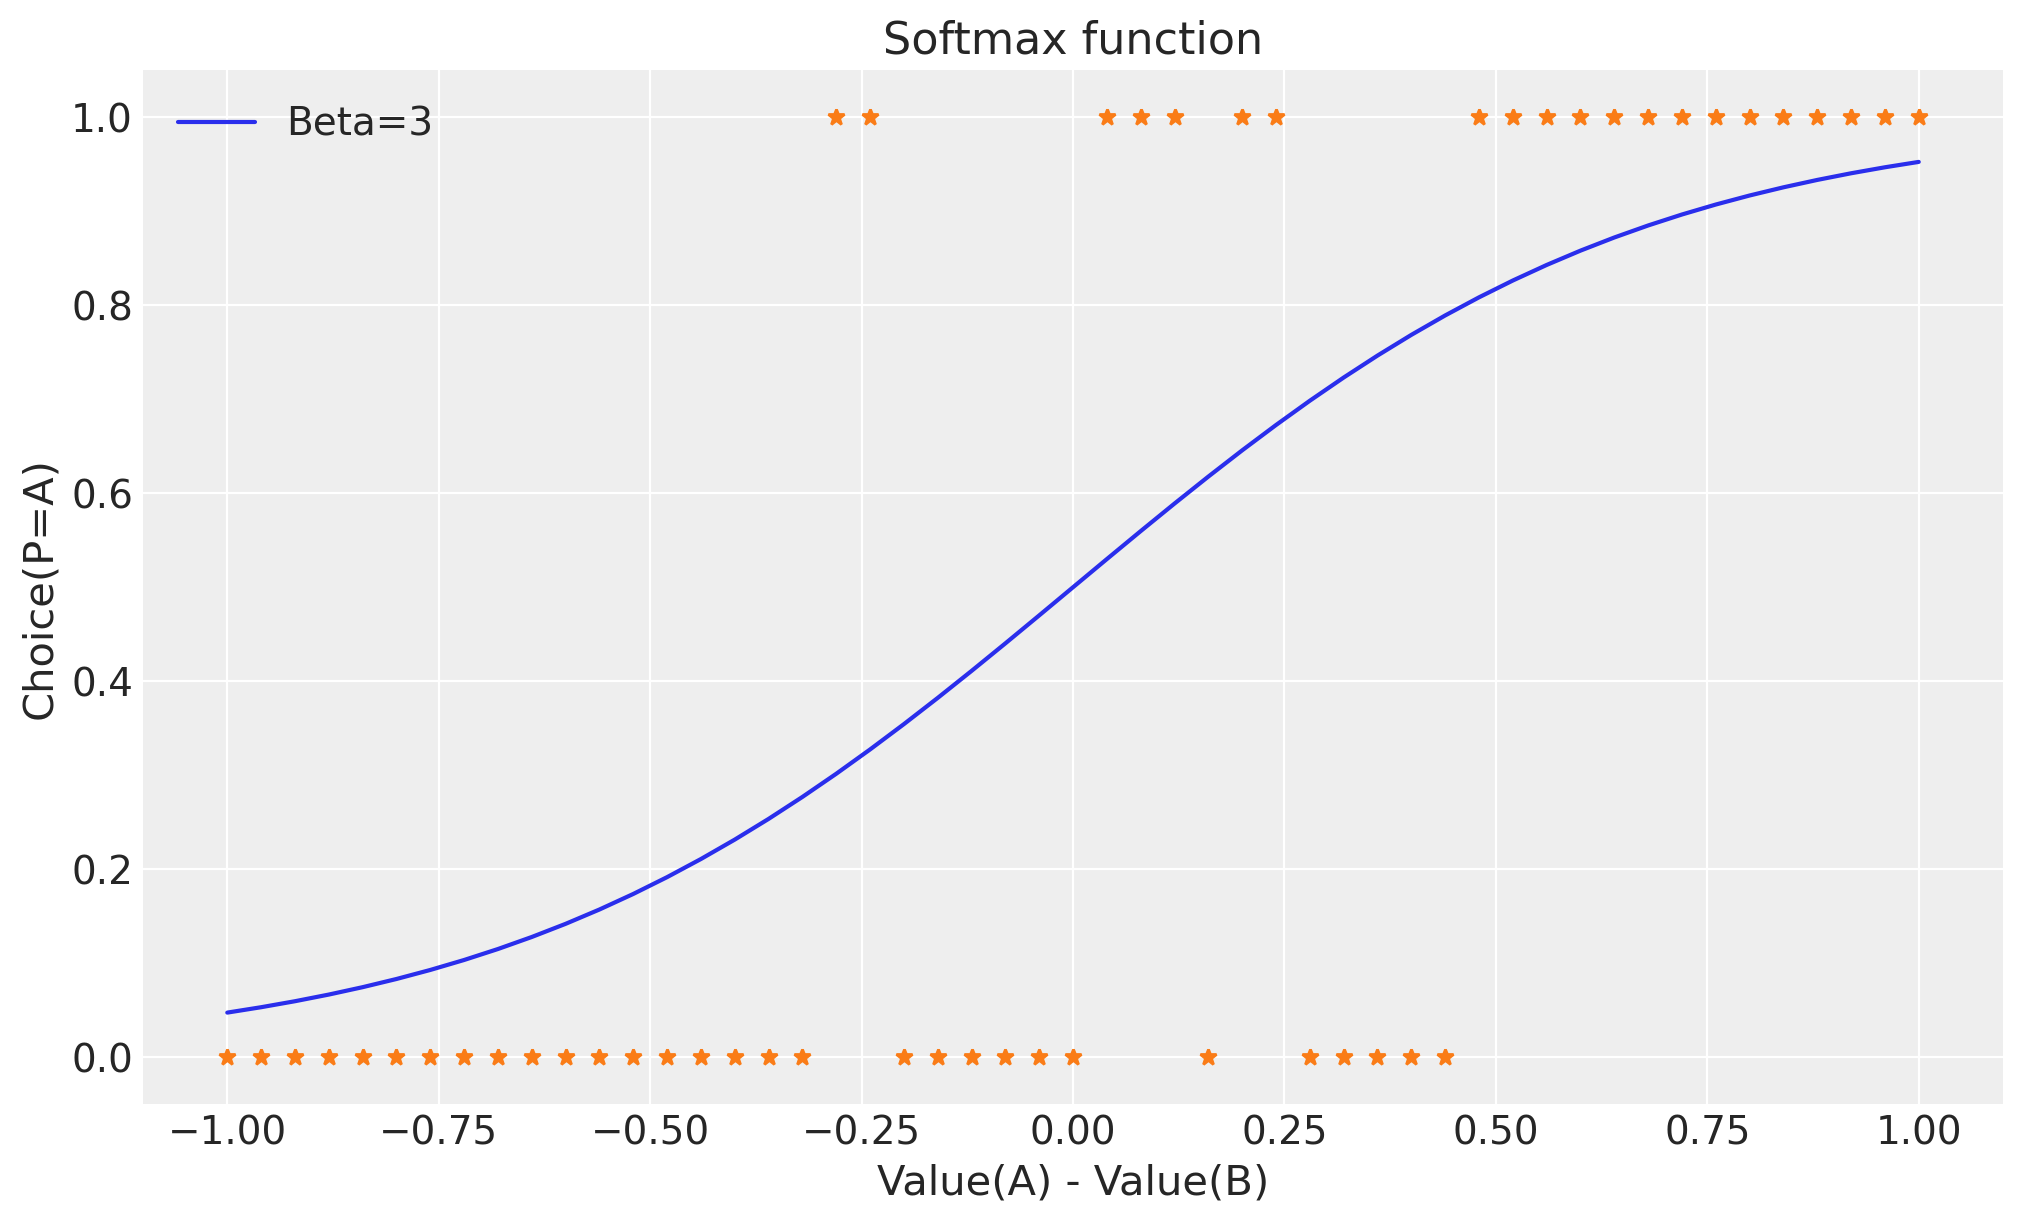

In [5]:
pa, data, x_axis = softmax()
beta = 3

plt.figure(figsize=(10, 6))
plt.plot(x_axis, pa, label="Beta=" + str(beta))
plt.plot(x_axis, data, marker="*", linestyle="None")

plt.title("Softmax function")
plt.ylabel("Choice(P=A)")
plt.xlabel("Value(A) - Value(B)")
plt.legend();

* La probabilità di scegliere lo stimolo A cresce in modo monotonico con la differenza di valore tra A e B.
* Gli asterischi indicano le scelte effettuate dal soggetto in base a queste probabilità di scelta; è evidente che il soggetto preferisce lo stimolo A nella maggior parte dei casi quando VA > vBB, ma non sempre.
* Da qui proviene il termine 'softmax': il soggetto sceglie lo stimolo con il valore massimo nella maggior parte dei casi, ma non sempre; pertanto, si parla di una funzione di massimizzazione 'soft'.
* Un valore di $\beta$ più elevato rende le scelte più 'deterministiche', cioè è più probabile che il partecipante scelga l'opzione con il valore più alto.
* Con un $\beta$ più basso, il partecipante diventa più 'esplorativo', ovvero è più propenso a scegliere anche l'altra opzione di tanto in tanto.

La funzione softmax svolge il ruolo di convertire i valori di $V$ e $\beta$ in una distribuzione di probabilità. Per illustrare meglio questo concetto, consideriamo di mantenere costanti i valori di $V$ (ad esempio, 0.1 per A e 0.75 per B) e di variare il parametro $\beta$. In altre parole, stiamo esaminando come cambia la probabilità di scelta quando la "temperatura" $\beta$ varia.

In [6]:
v = np.array([0.1, 0.75])

In [7]:
# Ridefiniamo la funzione softmax in modo tale che dipenda solo da V e beta.
def softmax(V, beta):
    p = np.exp(beta * V) / np.sum(np.exp(beta * V))
    return p

Definiamo un insieme di 100 valori beta compresi tra 0 e 5.

In [8]:
beta_values = np.linspace(0, 5, 100)

Finalmente, calcoliamo la probabilità.

In [9]:
probability_array = np.zeros((2, 100))  # Initialize an array to store probabilities

for i, beta in enumerate(beta_values):
    probability_array[:, i] = softmax(v, beta)

Esploriamo passo dopo passo il codice precedente:

```python
probability_array = np.zeros((2, 100))  
```

Qui viene creato un array NumPy chiamato `probability_array` con dimensioni `(2, 100)`. Questo array sarà utilizzato per immagazzinare le probabilità calcolate dalla funzione `softmax` per ogni valore di `beta`. La prima dimensione rappresenta il numero di opzioni (2 opzioni nel nostro caso), mentre la seconda dimensione rappresenta il numero di diversi valori di `beta` (100 nel nostro caso). 

```python
for i, beta in enumerate(beta_values):
    probability_array[:, i] = softmax(v, beta)
```

Qui, viene usato un ciclo `for` per iterare su ciascun valore di `beta` nell'array `beta_values`. La funzione `enumerate` fornisce sia l'indice `i` che il valore `beta` dall'array `beta_values`. Ad ogni iterazione, vengono calcolate le probabilità usando la funzione `softmax` per le opzioni specificate nell'array `v` e il valore corrente di `beta`.

La riga `probability_array[:, i]` assegna le probabilità calcolate alla colonna corrispondente nell'array `probability_array` per il valore corrente di `beta`. La notazione di indicizzazione `[:, i]` seleziona tutte le righe (opzioni) nella colonna corrente `i` dell'array `probability_array`.

Alla fine di questo ciclo, l'array `probability_array` conterrà i valori delle probabilità calcolate usando la funzione `softmax` per diverse combinazioni di valori di `beta` e opzioni.

In sintesi, il codice inizializza un array per contenere le probabilità e poi utilizza un ciclo per calcolare e memorizzare le probabilità per vari valori di `beta` e opzioni utilizzando la funzione `softmax`.

In [10]:
probability_array.shape

(2, 100)

Passiamo ora a creare un grafico che esprime la probabilità di scelta in funzione del valore beta.

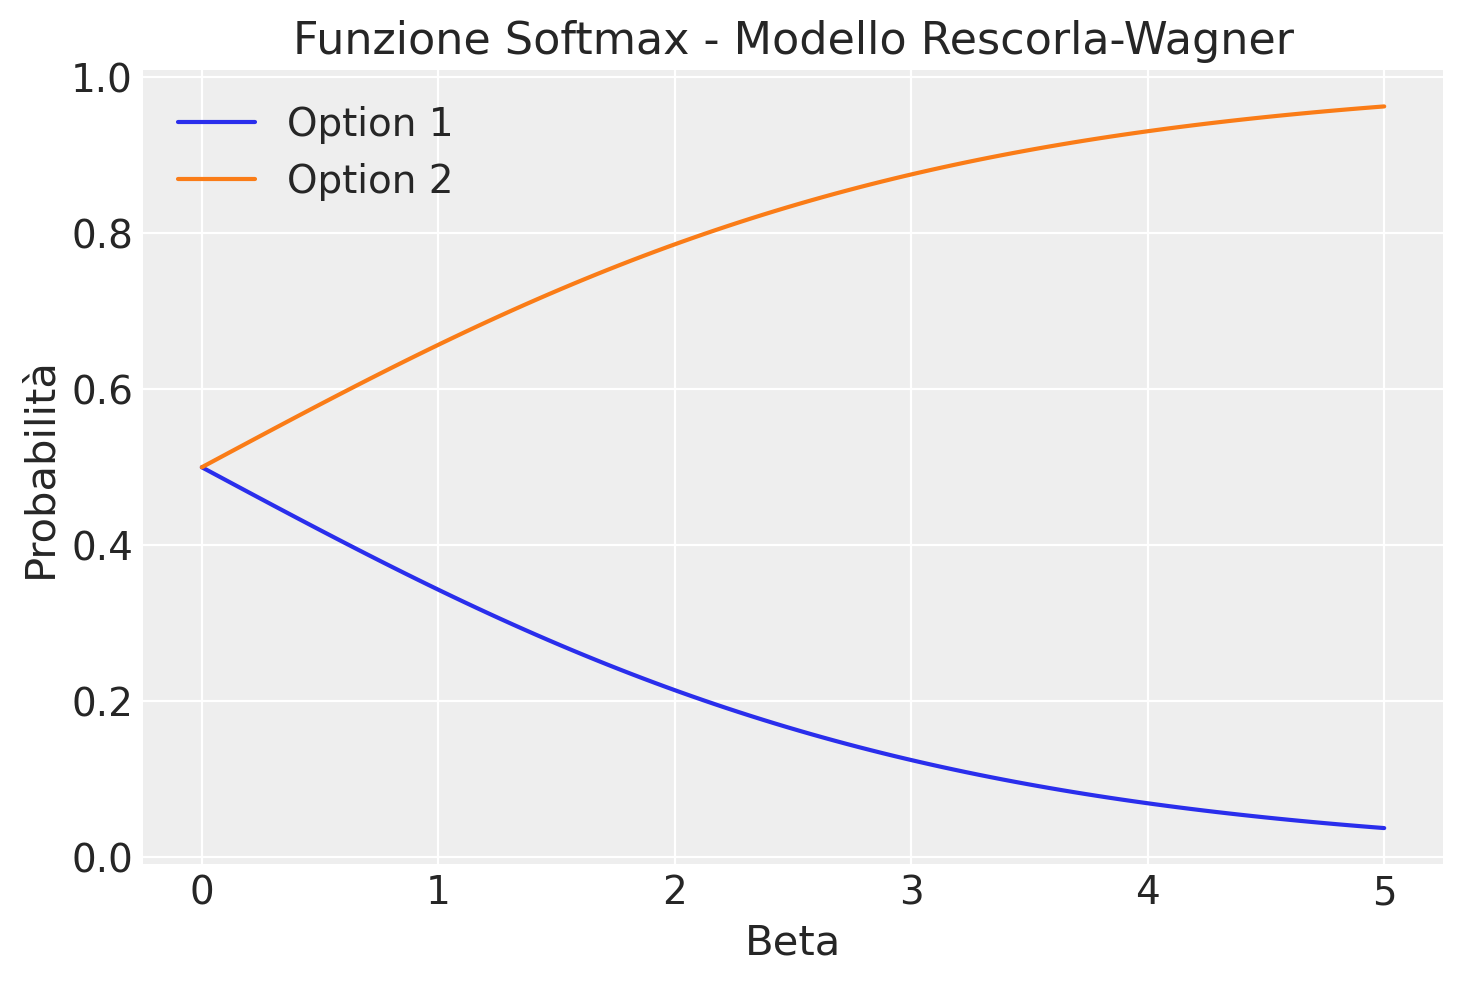

In [11]:
option_labels = ['Option 1', 'Option 2']

plt.figure()
for i in range(len(option_labels)):
    plt.plot(beta_values, probability_array[i], label=option_labels[i])

plt.xlabel("Beta")
plt.ylabel("Probabilità")
plt.title("Funzione Softmax - Modello Rescorla-Wagner")
plt.legend()
plt.show()

Il grafico evidenzia come le probabilità di scelta variano al variare del parametro β, offrendo un'illustrazione dell'effetto di tale parametro sulla distribuzione di probabilità nel modello di Rescorla-Wagner. Quando β è prossimo a zero, la funzione softmax genera una distribuzione di probabilità uniforme, dando luogo a una scelta completamente casuale (0.5 per ciascuna delle due opzioni). Quando β tende all'infinito, la funzione softmax privilegia sempre l'opzione con il valore più elevato (l'opzione 2 ha un valore di 0.75, mentre l'opzione 1 ha un valore di 0.1), rendendo la scelta deterministica. In altre parole, un valore maggiore di β implica che l'opzione con il valore stimato più elevato (nel nostro caso, l'opzione 2) avrà una probabilità di scelta più elevata, mentre valori inferiori di β permettono una maggiore esplorazione delle opzioni con valori stimati più bassi.

Combinando la regola di apprendimento e la regola decisionale, otteniamo un modello del processo decisionale con due parametri liberi: il tasso di apprendimento α e la temperatura inversa β.

In [12]:
T = 100
K = 2
mu = [0.2, 0.8] # probabilità di ricompensa per la scelta delle due opzioni

In [13]:
def simulate_RescorlaWagner(params, T, mu):
    alpha, beta = params

    # Un array di zeri di lunghezza T; c = "choice" in [0, 1]; r = "reward".
    c = np.zeros((T), dtype=int)
    r = np.zeros((T), dtype=int)

    # Un array multidimensionale di zeri di dimensione 2xT
    V_stored = np.zeros((2, T), dtype=float)

    # Inizializza V per t == 0
    V = [0.5, 0.5]

    for t in range(T):
        # Salva i valori V per V_{t+1}
        V_stored[:, t] = V

        # Calcola le probabilità di scelta
        p0 = np.exp(beta * V[0]) / (np.exp(beta * V[0]) + np.exp(beta * V[1]))
        p1 = 1 - p0

        # Viene simulato un comportamento di scelta rumoroso in cui l'opzione 0
        # è scelta con probabilità p0, mentre l'opzione 1 è scelta con
        # probabilità 1-p0. 
        # `np.random.random_sample(1)` genera un valore casuale tra 0 e 1. `p0` 
        # rappresenta la probabilità di scegliere l'opzione 0. L'istruzione `if` 
        # verifica se il valore casuale generato è minore di p0. Se lo è, l'agente 
        # sceglie l'opzione 0 (`c[t] = 0`). Se il valore casuale non è minore di p0, 
        # l'agente sceglie l'opzione 1 (`c[t] = 1`).
        if np.random.random_sample(1) < p0:
            c[t] = 0
        else:
            c[t] = 1
       
        # Genera la ricompensa sulla base delle probabilità di ricompensa.
        # Il confronto `np.random.rand() < mu[c[t]]` determina se viene ricevuta una 
        # ricompensa in base alla probabilità definita per l'opzione scelta. Se il valore 
        # casuale generato è minore della probabilità di ricompensa (`mu`), allora viene 
        # ricevuta una ricompensa (`r[t]` viene impostato su `True`); in caso contrario, 
        # non viene ricevuta alcuna ricompensa (`r[t]` viene impostato su `False`).
        r[t] = np.random.rand() < mu[c[t]]

        # Aggiorna le aspettative di valore
        delta = r[t] - V[c[t]]
        V[c[t]] = V[c[t]] + alpha * delta

    return c, r, V_stored

Simuliamo `T` = 100 prove utilizzando il modello generativo dei dati definito in precedenza.

In [14]:
c3, r3, V = simulate_RescorlaWagner([.1, 2.5], T=T, mu=mu)

Rappresentiamo graficamente i risultati ottenuti dalla simulazione.

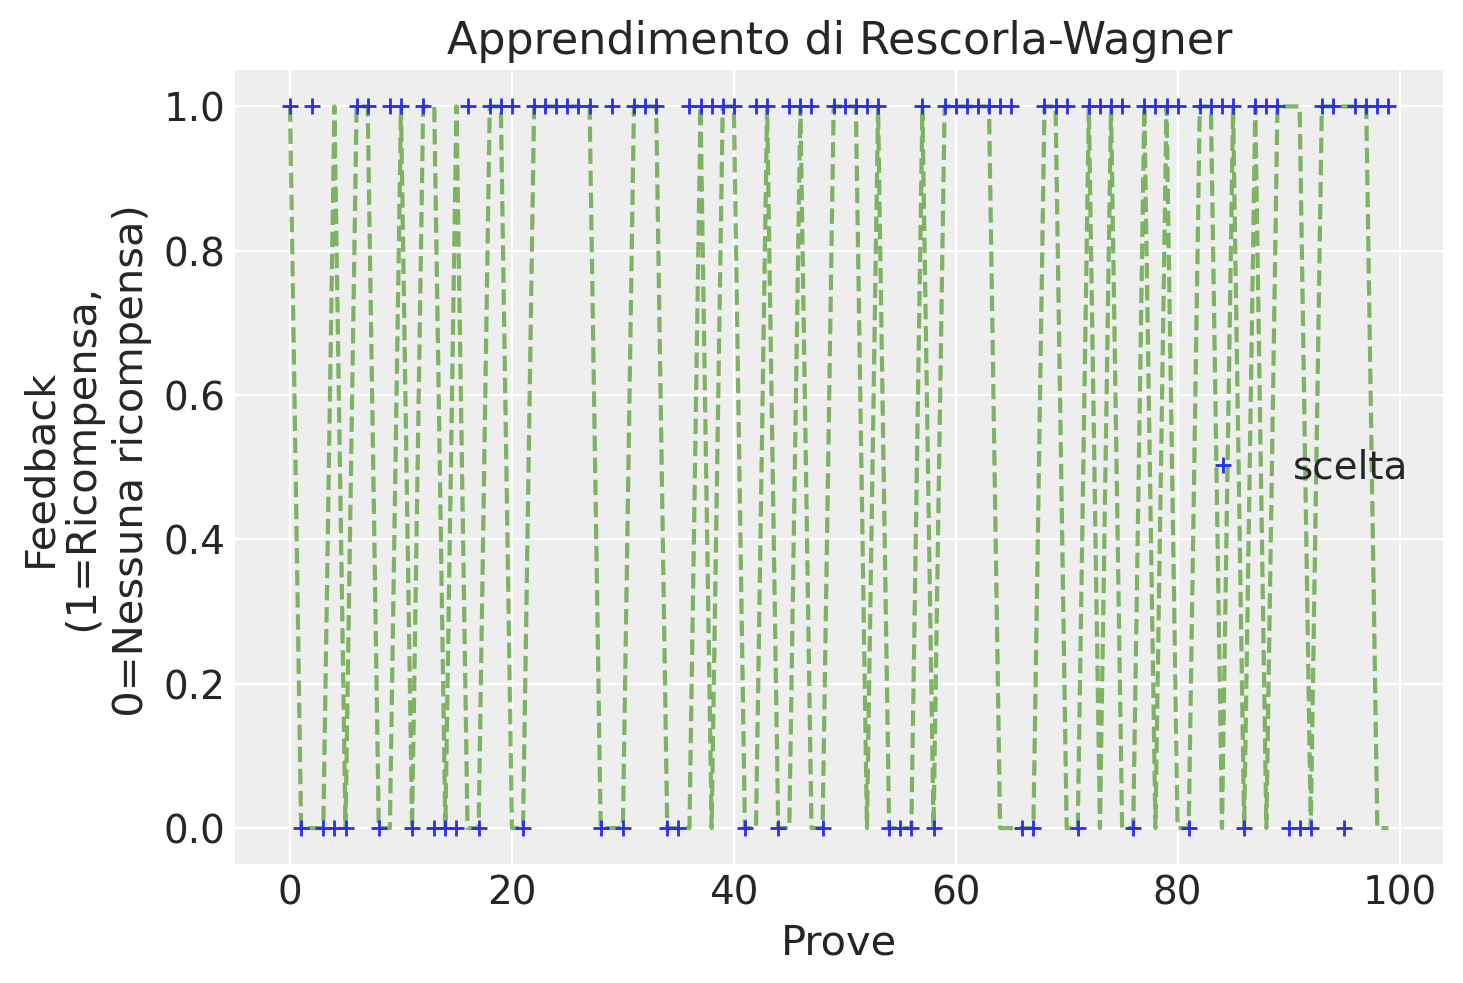

In [15]:
plt.figure()
plt.plot(range(T), r3, "C2--", alpha=0.6)
plt.plot(range(T), c3, "+", label="scelta")
plt.xlabel("Prove")
plt.ylabel("Feedback\n (1=Ricompensa,\n 0=Nessuna ricompensa)")
plt.title(f"Apprendimento di Rescorla-Wagner")
plt.legend();

Come possiamo osservare, le scelte per la slot machine che produce meno ricompense diventano meno frequenti nel corso delle prove.

Possiamo anche rappresentare graficamente le aspettative di valore $V$ delle due slot machine nel corso delle prove. 

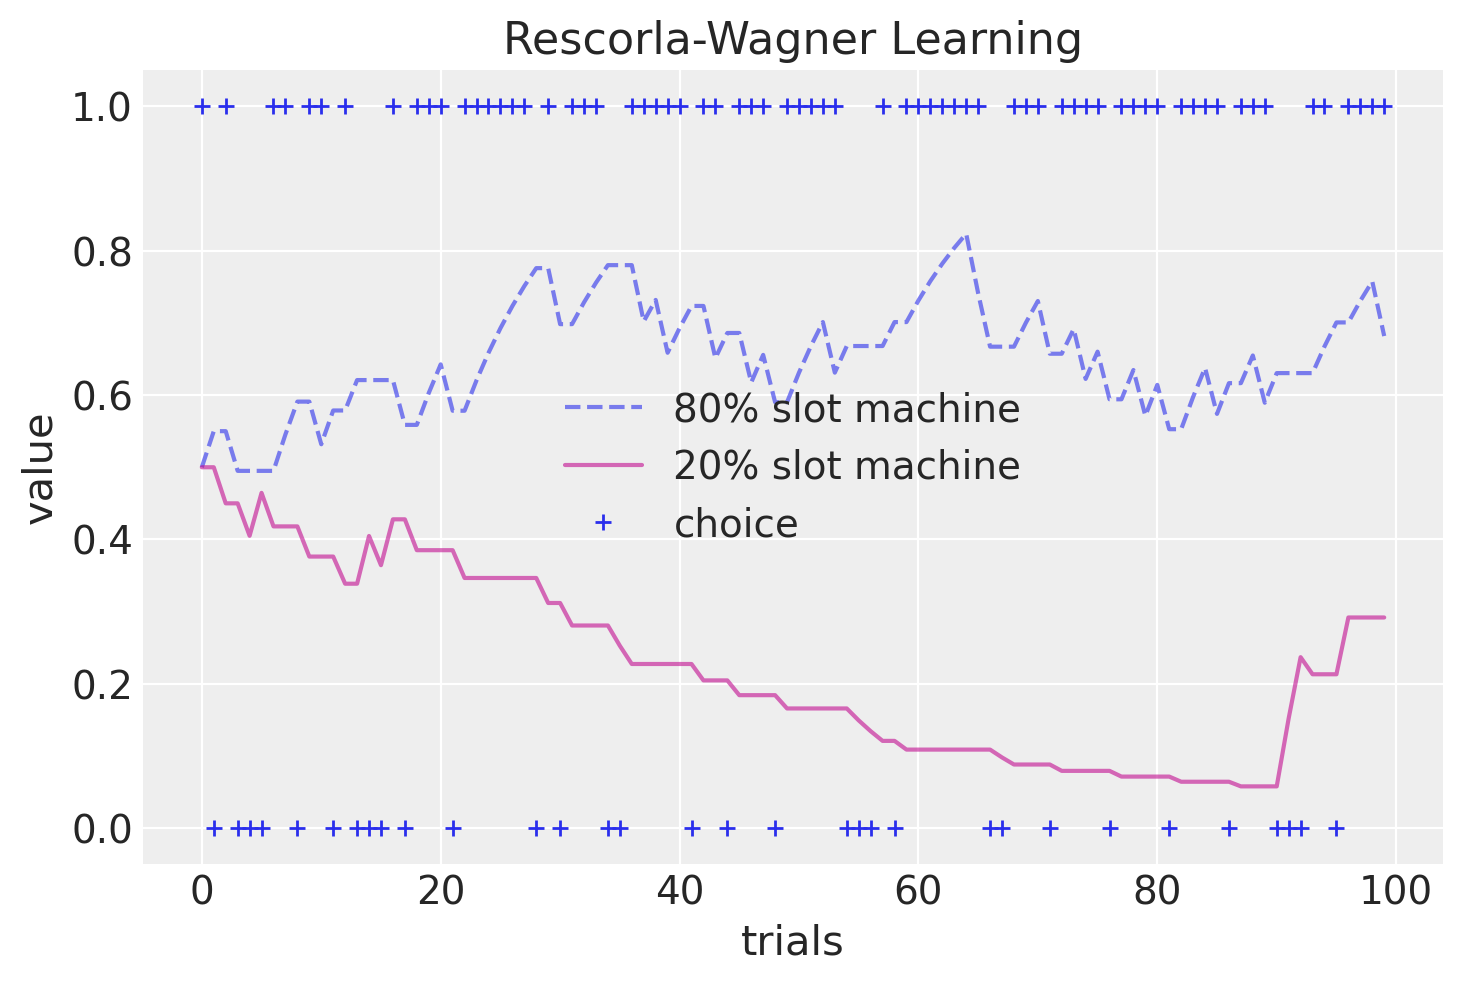

In [16]:
plt.figure()
plt.plot(range(T), V[1, :], "C0--", alpha=0.6, label="80% slot machine")
plt.plot(range(T), V[0, :], "C3-", alpha=0.6, label="20% slot machine")
plt.plot(range(T), c3, "C0+", label="choice")
plt.xlabel("trials")
plt.ylabel("value")
plt.title(f"Rescorla-Wagner Learning")
plt.legend();

Si noti come nel corso delle prove i valori delle slot macchine convergano lentamente verso le probabilità di ricompensa (20% e 80%).

## Stima dei parametri del modello

Dopo aver esaminato un'implementazione possibile del modello generativo dei dati di Rescorla-Wagner, affrontiamo ora la sfida di stimare i parametri del modello a partire dai dati osservati. Nella modellazione computazionale, una componente fondamentale è la stima dei valori dei parametri che meglio descrivono i dati comportamentali. Sebbene esistano diversi metodi di stima dei parametri, ci concentreremo sull'approccio della *Massima Verosimiglianza* (si veda l'Appendice di [Wilson & Collins (2019)](https://elifesciences.org/articles/49547)).

Nell'approccio della massima verosimiglianza, l'obiettivo è trovare i valori dei parametri di un modello $m$ che massimizzano la probabilità dei dati $d_{1:T}$. Nel caso del modello di Rescorla-Wagner, vogliamo massimizzare la probabilità dei dati $d_{1:T}$ alla luce dei valori dei parametri $(\alpha, \beta)_m$ del modello $m$.

### Calcolo del logaritmo negativo della verosimiglianza

Massimizzare la verosimiglianza è equivalente a massimizzare il logaritmo della verosimiglianza, $\log \mathcal{L} = \log p( d_{1:t-1} | (\alpha, \beta)_m, m)$, che è più conveniente da gestire numericamente. Il logaritmo della verosimiglianza può essere espresso in termini delle probabilità di ogni singola scelta come

$$
\log \mathcal{L} = \log p(d_{1:T} | (\alpha, \beta)_m, m) = \sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \beta)_m, m)
$$

dove $p(c_t | d_{1:t-1}, s_t, (\alpha, \beta)_m, m)$ rappresenta la *probabilità di ogni singola scelta* dati i parametri del modello e le informazioni disponibili fino a quella scelta (nella notazione precedente, $d$ sono i feedback e $s$ è lo stimolo, cioè la slot machine).

Massimizzare il logaritmo della verosimiglianza è equivalente a minimizzare il logaritmo negativo della verosimiglianza. Pertanto, possiamo riscrivere l'equazione precedente come:

$$
-\log \mathcal{L} = -\sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \beta)_m, m)
$$

Nella pratica, la verosimiglianza è semplicemente una funzione dei dati e dei parametri del modello. Nel caso del modello di Rescorla-Wagner, possiamo definire la funzione log-verosimiglianza negativa come:

In [17]:
def negll_RescorlaWagner(params, c, r):
    alpha, beta = params

    V = [0.5, 0.5]
    T = len(c)
    choiceProb = np.zeros((T), dtype=float)

    for t in range(T):
        # Calcola le probabilità di scelta per k = 2
        p0 = np.exp(beta * V[0]) / (np.exp(beta * V[0]) + np.exp(beta * V[1]))
        # "p" è una lista di probabilità di scelta per le due opzioni disponibili, in
        # cui p[0] rappresenta la probabilità di scegliere l'opzione 1 e p[1] rappresenta
        # la probabilità di scegliere l'opzione 2.
        p = [p0, 1 - p0]

        # La variabile "c[t]" indica l'opzione effettivamente scelta al tempo "t", che può
        # essere 0 o 1. Quindi "p[c[t]]" seleziona l'elemento corrispondente nell'elenco
        # delle probabilità di scelta. Ad esempio, se "c[t]" è uguale a 0, "p[c[t]]"
        # restituirà p[0], ovvero la probabilità di scegliere l'opzione 1. Allo stesso
        # modo, se "c[t]" è uguale a 1, "p[c[t]]" restituirà p[1], ovvero la probabilità
        # di scegliere l'opzione 2.
        choiceProb[t] = p[c[t]]

        # Aggiorniamo le aspettative di valore secondo la regola di Rescorla-Wagner.
        delta = r[t] - V[c[t]]
        V[c[t]] = V[c[t]] + alpha * delta

    # Una volta trovate le probabilità associate a ciascuna scelta, otteniamo il negativo
    # della log-verosimiglianza
    negLL = -np.sum(np.log(choiceProb))

    return negLL

Simuliamo ora un set di dati.

In [18]:
# simulate choices from RW Model
alpha = 0.2
beta = 1.5
c4, r4, V2 = simulate_RescorlaWagner([alpha, beta], T=T, mu=[0.2, 0.8])

Per fare un esempio, valutiamo la log-verosimiglianza negativa per i dati simulati in corrispondenza dei valori `alpha` e `theta` indicati di seguito.

In [19]:
alpha_hat = 0.3
beta_hat = 2.5
negLL = negll_RescorlaWagner([alpha_hat, beta_hat], c4, r4)
print(alpha_hat, beta_hat, negLL)

0.3 2.5 68.52600058524918


In [20]:
alpha_hat = 0.2
beta_hat = 1.5
negLL = negll_RescorlaWagner([alpha_hat, beta_hat], c4, r4)
print(alpha_hat, beta_hat, negLL)

0.2 1.5 62.90586040224763


Un metodo semplice per determinare i parametri attraverso la massima verosimiglianza prevede una ricerca esaustiva all'interno dell'intero spazio dei parametri. Questo significa selezionare i valori di `alpha` e `beta` che minimizzano il valore della funzione `negLL`.

Applichiamo questo approccio al set di dati simulato. Per semplicità, supponiamo di conoscere il valore di $\beta$, ma di non avere informazioni sul valore di $\alpha$.

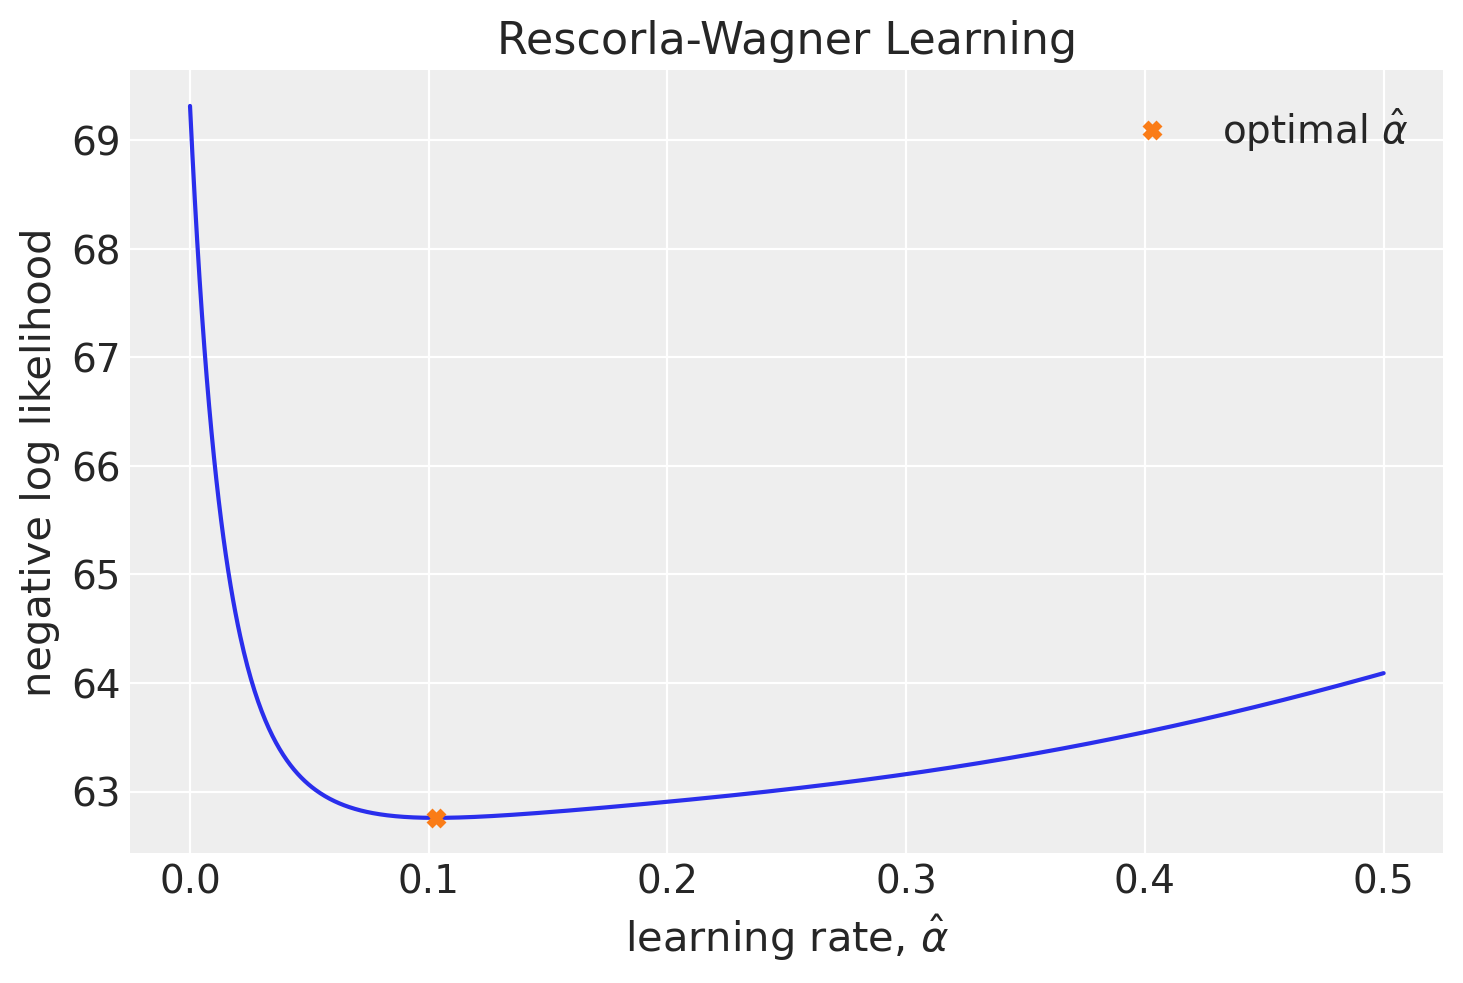

In [21]:
nLL = []
alpha_vals = np.linspace(0, 0.5, 1000)
for alpha_val in alpha_vals:
    nLL.append(negll_RescorlaWagner([alpha_val, beta], c4, r4))

plt.figure()
plt.plot(alpha_vals, nLL, "-")
plt.plot(
    alpha_vals[np.argmin(nLL)], nLL[np.argmin(nLL)], "X", label=r"optimal $\hat \alpha$"
)
plt.ylabel("negative log likelihood")
plt.xlabel(rf"learning rate, $\hat \alpha$")
plt.title(f"Rescorla-Wagner Learning")
plt.legend();

## Validazione

Una volta trovato un metodo per stimare i parametri del modello a partire dai dati ci dobbiamo chiedere quale sia il tipo di corrispondenza che ci possiamo aspettare tra le stime ottenute e i veri valori dei parametri del modello. Per rispondere a questa domanda è possibile svolgere uno studio di simulazione.

I parametri della simulazione sono i seguenti.

In [22]:
T = 250
mu = [0.2, 0.8]
NSUBJ = 500

Riscriviamo qui la funzione per il calcolo della log-verosimiglianza.

In [23]:
def negll_RescorlaWagner(params, choices, outcomes):
    alpha, beta = params

    if np.isnan(alpha) or np.isnan(beta):  # check inputs
        return np.inf

    else:
        c, r = choices, outcomes

        T = len(c)
        V = [0.5, 0.5]  # Q at trial 0
        V_stored = np.zeros((2, T), dtype=float)
        choiceProb = np.zeros((T), dtype=float)

        for t in range(T):  # add comment
            # compute choice probabilities for k=2
            # use the softmax rule
            ev = np.exp(beta * np.array(V))
            sum_ev = np.sum(ev)
            p = ev / sum_ev

            # compute choice probability for actual choice
            choiceProb[t] = p[c[t]]

            # update values
            delta = r[t] - V[c[t]]
            V[c[t]] = V[c[t]] + alpha * delta

            # store Q_t+1
            V_stored[:, t] = V

        negLL = -np.sum(np.log(choiceProb))  # add comment

        return negLL

Calcolimo i valori di massima verosimiglianza dei parametri `alpha` e `theta` usando la funzione `minimize` per minimizzare la funzione di log-verosimiglianza. Simuliamo i dati di un soggetto.

Specifichiamo poi le stime iniziali per i valori dei parametri e i valori margine delle possibili soluzioni. I risultati saranno salvati nell'oggetto `result`. Le stime dei due parametri si estraggono con `result.x`.

In [24]:
c, r, V = simulate_RescorlaWagner([0.15, 1.5], T=T, mu=mu)

init_guess = (0.1, 0.1)

# minimize neg LL
result = minimize(
    negll_RescorlaWagner,
    init_guess,
    (c, r),
    bounds=((0, 1), (0, 10)),
)
print(result.x)

[0.05155418 1.5622571 ]


Simuliamo i dati per 500 soggetti, con 250 osservazioni ciascuno, utilizzando valori casuali di `alpha` e `theta`. Successivamente, eseguiamo la stima di massima verosimiglianza per i dati di ogni soggetto, inizializzando casualmente i parametri per ciascuno di essi. Infine, salviamo i risultati ottenuti nel DataFrame `df`. Ecco il codice corrispondente:

In [25]:
df = pd.DataFrame(
    index=range(0, NSUBJ), columns=["true_alpha", "alpha", "true_beta", "beta"]
)

# loop through subjects
for index in range(NSUBJ):
    true_alpha = 0.95 * np.random.random()
    true_beta = 4.0 * np.random.random()

    c, r, V = simulate_RescorlaWagner([true_alpha, true_beta], T=250, mu=mu)

    init_guess = (0.2 * np.random.random(), 1.0 * np.random.random())
    # minimize neg LL
    param_fits = minimize(
        negll_RescorlaWagner,
        init_guess,
        (c, r),
        bounds=((0, 1), (0, 10)),
    )

    # store in dataframe
    df.at[index, "true_alpha"] = true_alpha
    df.at[index, "true_beta"] = true_beta
    df.at[index, "alpha"] = param_fits.x[0]
    df.at[index, "beta"] = param_fits.x[1]

La figura successiva mostra una corrispondenza tra i valori stimati di alpha e i valori veri. Tuttavia, è importante notare che la corrispondenza non è perfetta a causa della presenza di una componente di casualità nei dati. Inoltre, in alcuni casi si possono osservare valori stimati di alpha pari a 0 o 1, che corrispondono a risultati spurii dell'algoritmo. Il numero di risultati spurii aumenta con il diminuire del numero di osservazioni per ciascun soggetto.

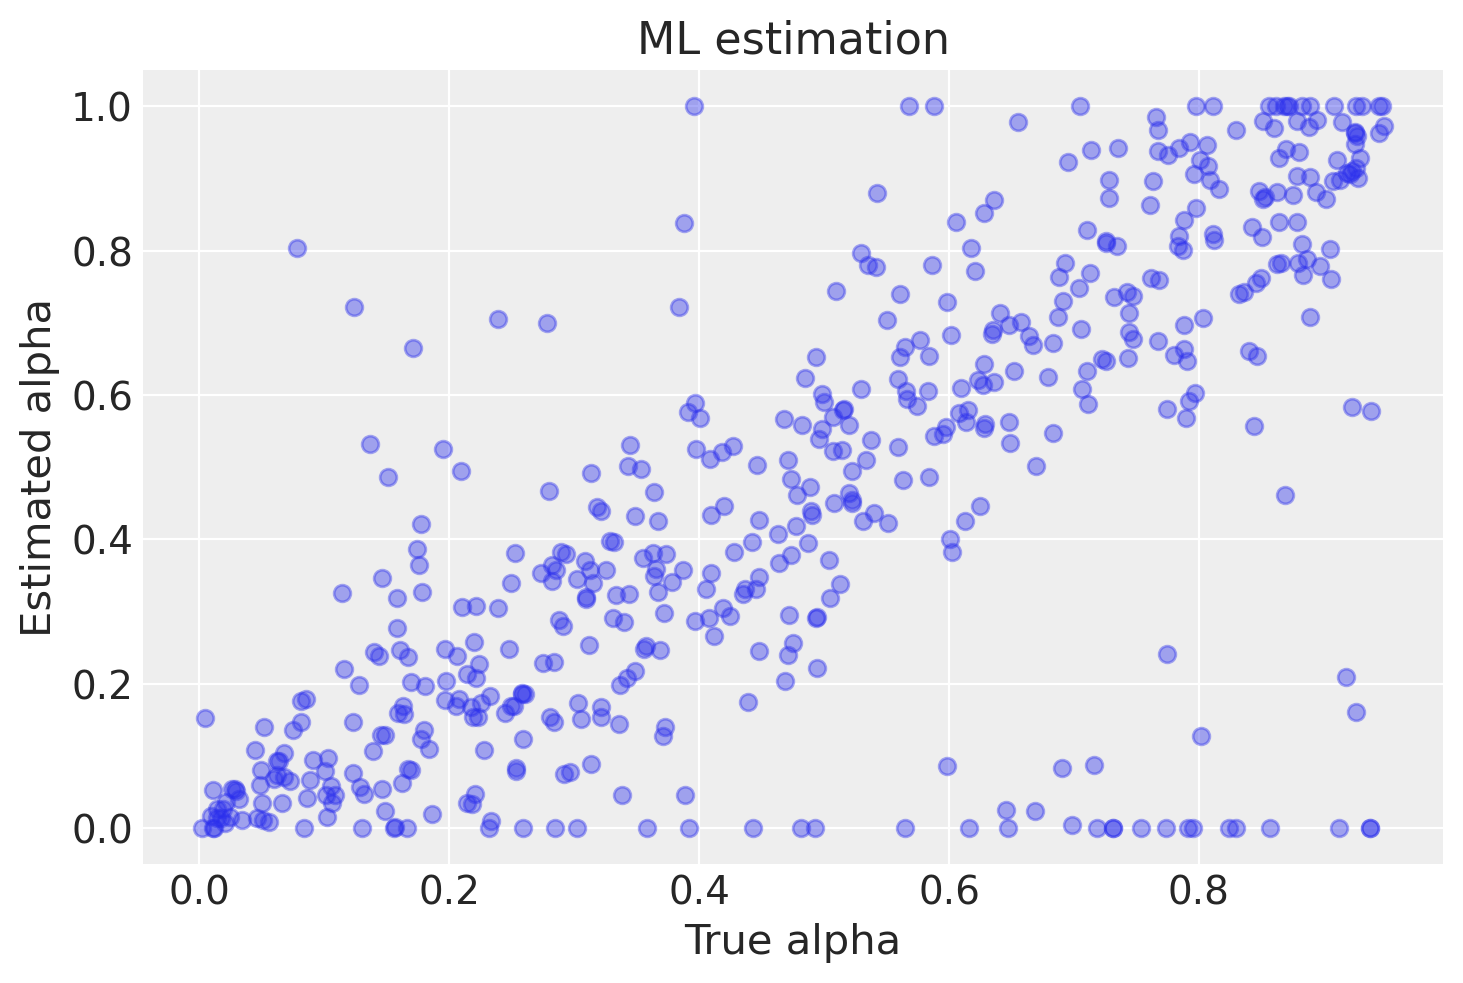

In [26]:
plt.figure()
plt.plot(df.true_alpha, df.alpha, "C0o", alpha=0.4)
plt.xlabel("True alpha")
plt.ylabel("Estimated alpha")
plt.title(f"ML estimation");

Un discorso analogo si può fare per theta, anche se in questo caso vi è una migliore corrispondenza tra i valori stimati e i valori veri.

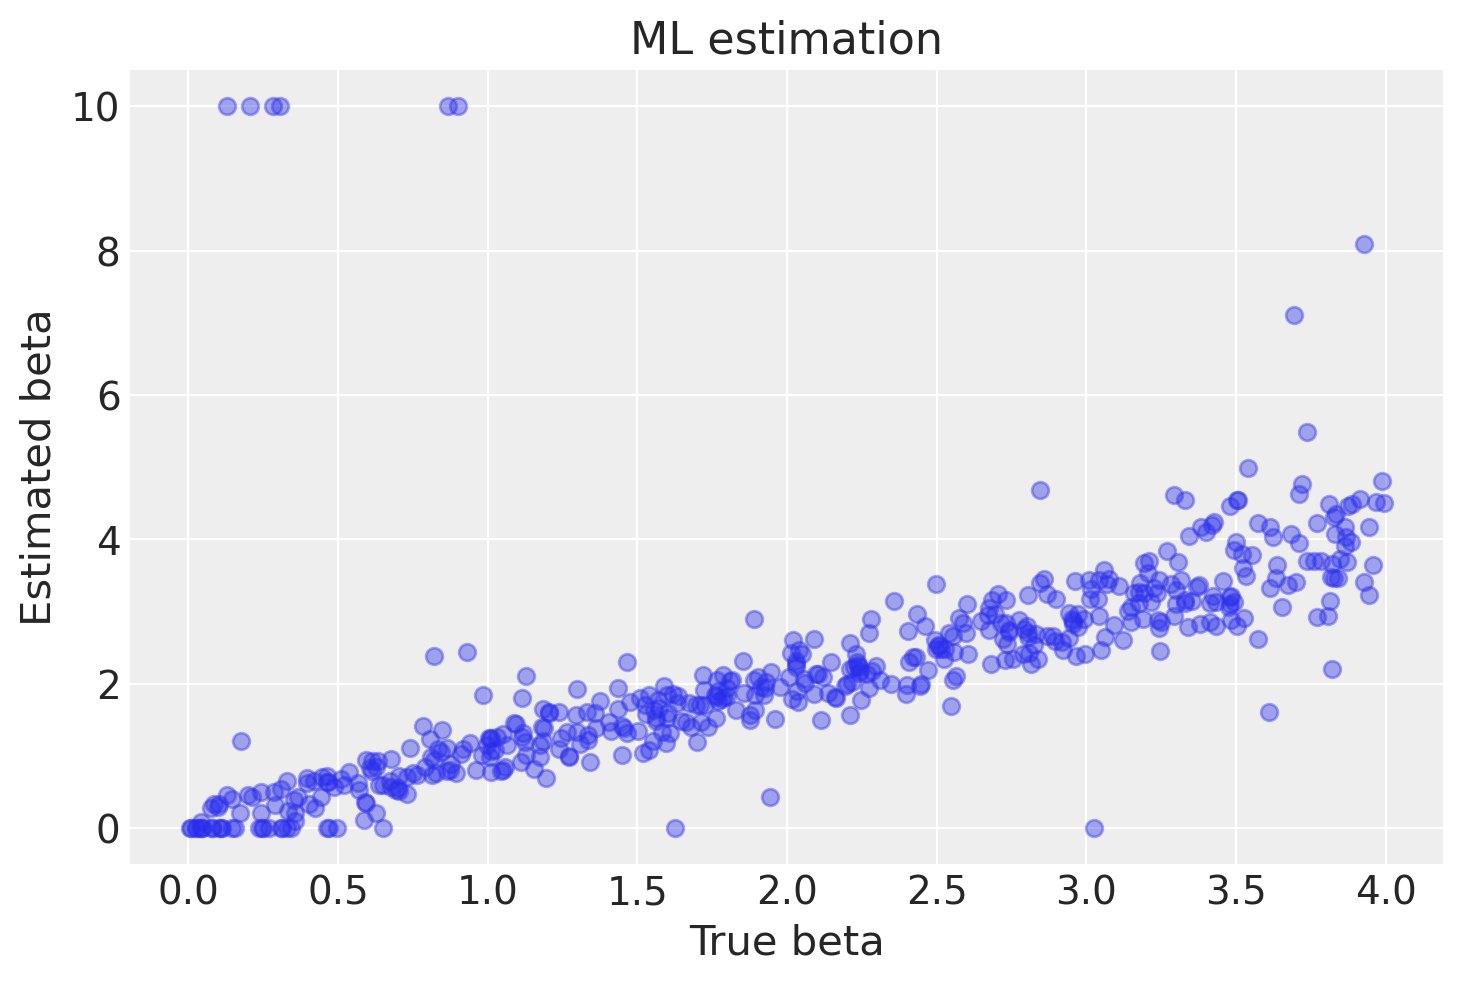

In [27]:
plt.figure()
plt.plot(df.true_beta, df.beta, "C0o", alpha=0.4)
plt.xlabel("True beta")
plt.ylabel("Estimated beta")
plt.title(f"ML estimation");

In sintesi, possiamo affermare che il metodo di massima verosimiglianza è in grado di recuperare i valori simulati dei parametri `alpha` e `beta` del modello Rescorla-Wagner, ma solo quando il numero di osservazioni per soggetto è considerevole. Tuttavia, è importante sottolineare che questo metodo può produrre risultati erronei in specifiche circostanze.

Esistono altri metodi di stima che offrono risultati migliori anche con un numero inferiore di osservazioni per soggetto. Tra questi, il metodo gerarchico bayesiano è ampiamente utilizzato nella pratica. Va però precisato che l'obiettivo di questo tutorial era principalmente illustrare in modo semplice come sia possibile ottenere con buona accuratezza i parametri del modello Rescorla-Wagner dai dati generati da una simulazione, considerando condizioni ottimali in cui i valori dei parametri del modello sono noti.

## Commenti e considerazioni conclusive

È fondamentale sottolineare che, nella pratica, la stima dei parametri è un processo complesso e che l'accuratezza delle stime dipende da vari fattori, come la dimensione del campione e la natura dei dati osservati. Pertanto, è sempre consigliabile valutare attentamente i risultati e considerare l'utilizzo di approcci più sofisticati, come il metodo gerarchico bayesiano, per ottenere stime dei parametri del modello più affidabili.

## Watermark

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Nov 09 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

pandas    : 2.1.1
matplotlib: 3.8.0
arviz     : 0.16.1
numpy     : 1.25.2
seaborn   : 0.13.0

Watermark: 2.4.3

